In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import re # Regular expressions

from matplotlib import pyplot as plt # image visualization

# Image manipulation
from skimage import io


import keras

In [2]:
# Variable declaration
image_mode = "FLAIR" # FLAIR - T1w - T1wCE - T2w
patient_mode = "central" # central - first TODO: Explain 
input_dir = "../input/rsna-miccai-png/train" 
target_dir = "../input/rsna-miccai-png/test"

In [3]:
# Get path to the training images
input_img_paths_patients = sorted([
    os.path.join(input_dir, fname + "/" + image_mode) 
    for fname in os.listdir(input_dir)
    if os.path.exists(os.path.join(input_dir, fname + "/" + image_mode))])

# Read images
input_img_paths = []
for patient in input_img_paths_patients:
    # TODO: Explain
    # TODO: Choosing first makes no sense. Because of the way images are taken. Center or bigger
    images_id = x = [int(re.findall(r'\d+', x)[0]) for x in os.listdir(patient)] # Get all image ids
    if patient_mode == "central":
        index_central_image = min(images_id) + round((max(images_id) - min(images_id))/2) # Get middle image
        path = os.path.join(patient, "Image-" + str(index_central_image) + ".png")
        if os.path.exists(path): input_img_paths.append(path)
    if patient_mode == "first":
        index_central_image = min(images_id) # Get first image
        path = os.path.join(patient, "Image-" + str(index_central_image) + ".png")
        if os.path.exists(path): input_img_paths.append(path)
            
# Read csv labels
df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')

# Obtain pure labels
labels = []
for img_path in input_img_paths:
    labels.append(df.loc[df['BraTS21ID'] == int(re.findall(r'\d+', img_path)[0])]['MGMT_value'].iloc[0])

# **Data visualization**

Text(0.5, 1.0, 'Tumor presence: 0')

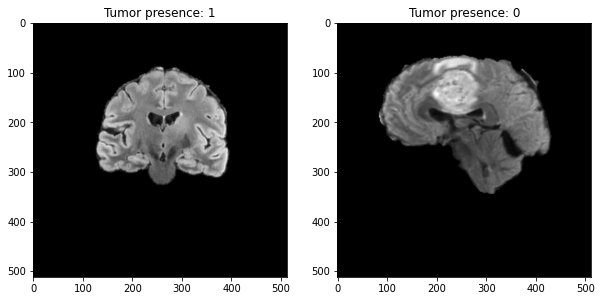

In [4]:
# Read training images and visualize
i = 0
while labels[0] == labels[i]: 
    i+=1

# Create figure
fig = plt.figure(figsize=(10, 10))

# Cetting values to rows and column variables
rows = 1
columns = 2

# Plot images - Visualize an image and it's segmentation
fig.add_subplot(rows, columns, 1)
plt.imshow(io.imread(input_img_paths[0]), cmap='gray')
plt.title(f"Tumor presence: {labels[0]}")

fig.add_subplot(rows, columns, 2)
plt.imshow(io.imread(input_img_paths[i]), cmap='gray')
plt.title(f"Tumor presence: {labels[i]}")

In [5]:
# Split data into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(input_img_paths, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.111, random_state=42) # 0.111*0.9 = 0.1

# Check amounts of data in each split
print(f"Training samples: {str(len(X_train))}\nValidation samples: {str(len(X_val))}\nTest samples: {str(len(X_test))}")

# Create dataframes for keras flow_from_dataframe
data = {'id': X_train, 'label': [str(x) for x in y_train]}
train_df = pd.DataFrame(data)

data = {'id': X_val, 'label': [str(x) for x in y_val]}
val_df = pd.DataFrame(data)

data = {'id': X_test, 'label': [str(x) for x in y_test]}
test_df = pd.DataFrame(data)

Training samples: 464
Validation samples: 59
Test samples: 59


In [6]:
def load_dataset(train_df, val_df, test_df, data_augmentation=False):
    """
    This function loads the dataset from dataset folder
    :parameter data_augmentation: Boolean indicating whether to include or not data augmentation
    :return train_generator: Training generator
    :return val_generator: Validation generator
    :return test_generator: Testing generator
    """

    # Create a data generator
    if data_augmentation:
        datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,
                                                                        rotation_range=20,
                                                                        width_shift_range=0.1,
                                                                        height_shift_range=0.1,
                                                                        zoom_range=0.2,
                                                                        horizontal_flip=True)
    else:
        datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
    datagen_val_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

    # Load and iterate training dataset
    train_generator=datagen_train.flow_from_dataframe(dataframe=train_df, x_col="id", y_col="label", class_mode="binary", batch_size=batch_size)
    # Load and iterate validation dataset
    val_generator=datagen_val_test.flow_from_dataframe(dataframe=val_df, x_col="id", y_col="label", class_mode="binary", batch_size=batch_size)
    # Load and iterate test dataset
    test_generator=datagen_val_test.flow_from_dataframe(dataframe=test_df, x_col="id", y_col="label", class_mode="binary", batch_size=batch_size)

    return train_generator, val_generator, test_generator